# Introduction
In this notebook, I will be analyzing how traffic data changes depending on the hour and the particular day. For my other analyses, see the other notebooks in the directory.

In [1]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.types as T
import pyspark
import pyspark.sql.functions as F
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams["axes.titlesize"] = 40
plt.rcParams["axes.labelsize"] = 15

# Part 1: Setting Up the Notebook
The first step will be to load in the data. Since the data is quite large, the data wrangling is done in PySpark.

In [3]:
data_dir = "../data/uber/uber-trip-data/"
uber_files = glob.glob(data_dir + '*.csv') 
uber_files

['../data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-may14.csv',
 '../data/uber/uber-trip-data/taxi-zone-lookup.csv',
 '../data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-sep14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-apr14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-aug14.csv']

In [4]:
uber_files.remove('../data/uber/uber-trip-data/taxi-zone-lookup.csv')

In [5]:
uber_files

['../data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-may14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-sep14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-apr14.csv',
 '../data/uber/uber-trip-data/uber-raw-data-aug14.csv']

In [6]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Word Count") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

22/05/09 18:26:40 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/05/09 18:26:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/09 18:26:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
df = spark.read.csv(uber_files, header=True)

In [8]:
df.show()

+----------------+-------+--------+------+
|       Date/Time|    Lat|     Lon|  Base|
+----------------+-------+--------+------+
|9/1/2014 0:01:00|40.2201|-74.0021|B02512|
|9/1/2014 0:01:00|  40.75|-74.0027|B02512|
|9/1/2014 0:03:00|40.7559|-73.9864|B02512|
|9/1/2014 0:06:00| 40.745|-73.9889|B02512|
|9/1/2014 0:11:00|40.8145|-73.9444|B02512|
|9/1/2014 0:12:00|40.6735|-73.9918|B02512|
|9/1/2014 0:15:00|40.7471|-73.6472|B02512|
|9/1/2014 0:16:00|40.6613|-74.2691|B02512|
|9/1/2014 0:32:00|40.3745|-73.9999|B02512|
|9/1/2014 0:33:00|40.7633|-73.9773|B02512|
|9/1/2014 0:33:00|40.7467|-73.6131|B02512|
|9/1/2014 0:37:00|40.8105|  -73.96|B02512|
|9/1/2014 0:38:00| 40.679|-74.0111|B02512|
|9/1/2014 0:39:00|40.4023|-73.9839|B02512|
|9/1/2014 0:48:00|40.7378|-74.0395|B02512|
|9/1/2014 0:48:00|40.7214|-73.9884|B02512|
|9/1/2014 0:49:00|40.8646|-73.9081|B02512|
|9/1/2014 1:08:00|40.7398|-74.0061|B02512|
|9/1/2014 1:17:00|40.6793|-74.0116|B02512|
|9/1/2014 1:19:00|40.7328|-73.9875|B02512|
+----------

In [9]:
df = df.withColumn("Date/Time", F.to_timestamp(F.col("Date/Time"), "M/d/yyyy H:mm:ss"))

In [10]:
df.show()

+-------------------+-------+--------+------+
|          Date/Time|    Lat|     Lon|  Base|
+-------------------+-------+--------+------+
|2014-09-01 00:01:00|40.2201|-74.0021|B02512|
|2014-09-01 00:01:00|  40.75|-74.0027|B02512|
|2014-09-01 00:03:00|40.7559|-73.9864|B02512|
|2014-09-01 00:06:00| 40.745|-73.9889|B02512|
|2014-09-01 00:11:00|40.8145|-73.9444|B02512|
|2014-09-01 00:12:00|40.6735|-73.9918|B02512|
|2014-09-01 00:15:00|40.7471|-73.6472|B02512|
|2014-09-01 00:16:00|40.6613|-74.2691|B02512|
|2014-09-01 00:32:00|40.3745|-73.9999|B02512|
|2014-09-01 00:33:00|40.7633|-73.9773|B02512|
|2014-09-01 00:33:00|40.7467|-73.6131|B02512|
|2014-09-01 00:37:00|40.8105|  -73.96|B02512|
|2014-09-01 00:38:00| 40.679|-74.0111|B02512|
|2014-09-01 00:39:00|40.4023|-73.9839|B02512|
|2014-09-01 00:48:00|40.7378|-74.0395|B02512|
|2014-09-01 00:48:00|40.7214|-73.9884|B02512|
|2014-09-01 00:49:00|40.8646|-73.9081|B02512|
|2014-09-01 01:08:00|40.7398|-74.0061|B02512|
|2014-09-01 01:17:00|40.6793|-74.0

In [11]:
df = df.withColumn("Count", F.lit(1))
df.show()

+-------------------+-------+--------+------+-----+
|          Date/Time|    Lat|     Lon|  Base|Count|
+-------------------+-------+--------+------+-----+
|2014-09-01 00:01:00|40.2201|-74.0021|B02512|    1|
|2014-09-01 00:01:00|  40.75|-74.0027|B02512|    1|
|2014-09-01 00:03:00|40.7559|-73.9864|B02512|    1|
|2014-09-01 00:06:00| 40.745|-73.9889|B02512|    1|
|2014-09-01 00:11:00|40.8145|-73.9444|B02512|    1|
|2014-09-01 00:12:00|40.6735|-73.9918|B02512|    1|
|2014-09-01 00:15:00|40.7471|-73.6472|B02512|    1|
|2014-09-01 00:16:00|40.6613|-74.2691|B02512|    1|
|2014-09-01 00:32:00|40.3745|-73.9999|B02512|    1|
|2014-09-01 00:33:00|40.7633|-73.9773|B02512|    1|
|2014-09-01 00:33:00|40.7467|-73.6131|B02512|    1|
|2014-09-01 00:37:00|40.8105|  -73.96|B02512|    1|
|2014-09-01 00:38:00| 40.679|-74.0111|B02512|    1|
|2014-09-01 00:39:00|40.4023|-73.9839|B02512|    1|
|2014-09-01 00:48:00|40.7378|-74.0395|B02512|    1|
|2014-09-01 00:48:00|40.7214|-73.9884|B02512|    1|
|2014-09-01 

In [12]:
df = df.withColumn("hour", F.hour(df["Date/Time"]))

In [13]:
hourly = df.groupBy(F.hour("Date/Time").alias("Time of Day")).agg(F.sum("Count").alias("Number of Trips"))

In [14]:
hourly.sort(F.col("Number of Trips").desc()).show()

+-----------+---------------+
|Time of Day|Number of Trips|
+-----------+---------------+
|         17|         336190|
|         18|         324679|
|         16|         313400|
|         19|         294513|
|         20|         284604|
|         21|         281460|
|         15|         275466|
|         22|         241858|
|         14|         230625|
|         13|         195877|
|          7|         193094|
|          8|         190504|
|         12|         170452|
|         23|         169190|
|         11|         165703|
|          9|         159967|
|         10|         159148|
|          6|         143213|
|          0|         103836|
|          5|          83939|
+-----------+---------------+
only showing top 20 rows



# Visualizing Hourly Data
The first thing I want to look at is the total number of Uber trips, separated by hour. There are times when there are a lot of cars on the road, and then there are times where there is no traffic.
I expect to see patterns of very little traffic, for example at odd hours, and patterns of high traffic perhaps representing rush hour/going places after work.

Text(0.5, 1.0, 'Total Number of Trips per Hour')

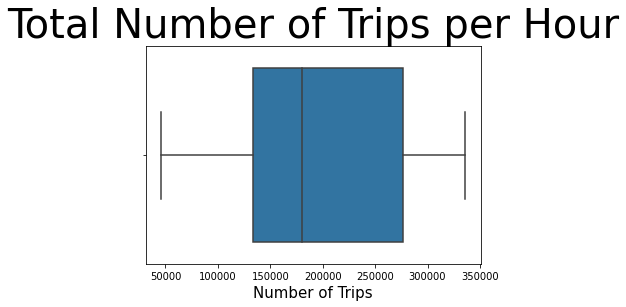

In [15]:
sns.boxplot(data=hourly.toPandas(), x = "Number of Trips")
plt.title("Total Number of Trips per Hour")

It looks like the overall distribution of hourly data is right skewed, so the mean will be larger than the median. However, it is not overly right skewed.

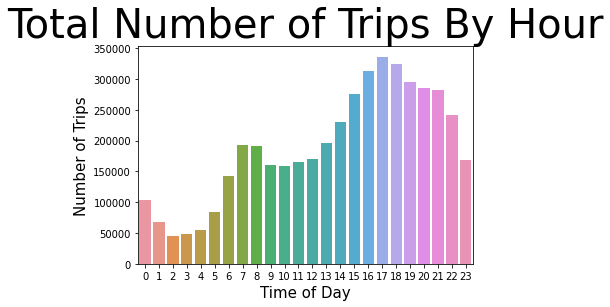

In [16]:
sns.barplot(data=hourly.toPandas(), x = "Time of Day", y="Number of Trips")
plt.title("Total Number of Trips By Hour")
plt.show()

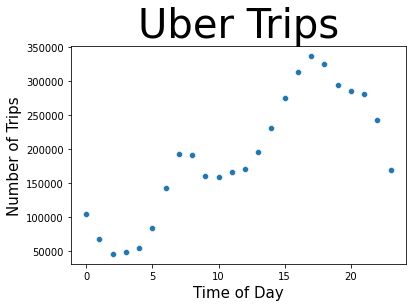

In [17]:
import seaborn as sns
test_df = hourly.toPandas()
sns.scatterplot(x = "Time of Day", y = "Number of Trips", data = test_df)
plt.title("Uber Trips")
plt.show()

It looks like overall, the total number of trips increases as the time goes on. There is a minor peak around 7-8 am, then less traffic, which may correspond to rush hour traffic. There are significantly more rides around 5-6pm, and a peak between 4-6 pm. Overall, the number of rides increase from 9-5, peak around 5, and gradually decrease until 11pm, but still remain significantly higher than in the morning.
One possible explanation could be that people tend to use Uber more for getting to and from parties later in the day and are less likely to do so in the morning.

In [18]:
daily = df.withColumn("Date/Time", F.date_trunc('dd', F.col('Date/Time')))
daily.show()

+-------------------+-------+--------+------+-----+----+
|          Date/Time|    Lat|     Lon|  Base|Count|hour|
+-------------------+-------+--------+------+-----+----+
|2014-09-01 00:00:00|40.2201|-74.0021|B02512|    1|   0|
|2014-09-01 00:00:00|  40.75|-74.0027|B02512|    1|   0|
|2014-09-01 00:00:00|40.7559|-73.9864|B02512|    1|   0|
|2014-09-01 00:00:00| 40.745|-73.9889|B02512|    1|   0|
|2014-09-01 00:00:00|40.8145|-73.9444|B02512|    1|   0|
|2014-09-01 00:00:00|40.6735|-73.9918|B02512|    1|   0|
|2014-09-01 00:00:00|40.7471|-73.6472|B02512|    1|   0|
|2014-09-01 00:00:00|40.6613|-74.2691|B02512|    1|   0|
|2014-09-01 00:00:00|40.3745|-73.9999|B02512|    1|   0|
|2014-09-01 00:00:00|40.7633|-73.9773|B02512|    1|   0|
|2014-09-01 00:00:00|40.7467|-73.6131|B02512|    1|   0|
|2014-09-01 00:00:00|40.8105|  -73.96|B02512|    1|   0|
|2014-09-01 00:00:00| 40.679|-74.0111|B02512|    1|   0|
|2014-09-01 00:00:00|40.4023|-73.9839|B02512|    1|   0|
|2014-09-01 00:00:00|40.7378|-7

In [19]:
daily = daily.groupBy(F.col("Date/Time").alias("Day")).agg(F.sum("Count").alias("Number of Trips"))
daily.show()

+-------------------+---------------+
|                Day|Number of Trips|
+-------------------+---------------+
|2014-07-30 00:00:00|          30740|
|2014-08-11 00:00:00|          22632|
|2014-07-16 00:00:00|          28607|
|2014-09-10 00:00:00|          35910|
|2014-08-12 00:00:00|          29646|
|2014-07-02 00:00:00|          26480|
|2014-07-12 00:00:00|          25936|
|2014-09-11 00:00:00|          36439|
|2014-08-28 00:00:00|          28597|
|2014-08-24 00:00:00|          22036|
|2014-08-17 00:00:00|          21209|
|2014-09-15 00:00:00|          29454|
|2014-09-12 00:00:00|          39540|
|2014-09-14 00:00:00|          28122|
|2014-09-02 00:00:00|          28831|
|2014-08-18 00:00:00|          21956|
|2014-09-28 00:00:00|          29656|
|2014-07-13 00:00:00|          21082|
|2014-07-10 00:00:00|          30541|
|2014-07-19 00:00:00|          25726|
+-------------------+---------------+
only showing top 20 rows



In [20]:
daily

DataFrame[Day: timestamp, Number of Trips: bigint]

In [21]:
import statsmodels.api as sm


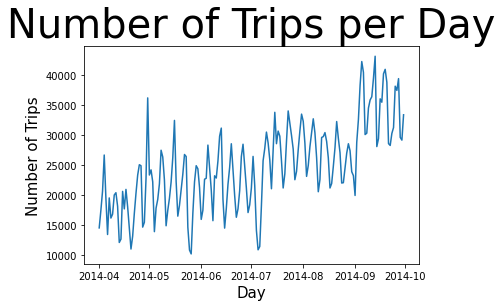

In [22]:
#sns.scatterplot(data=daily.toPandas(), x="Day", y = "Number of Trips")
sns.lineplot(data=daily.toPandas(), x="Day", y = "Number of Trips")
plt.title("Number of Trips per Day")
plt.show()

There is a steady increase in the number of rides from April 2014 - October 2014. Uber was launched in 2009, but launched Uber Rush and expansions in 2014. Smartphones became popular around 2012, and overtime, smartphones have become the norm. It is possible that the growth in Uber trips is because of the growth in smartphone usage, allowing people to use Uber, as well as Uber rides becoming more mainstream due to Uber's expansions.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as sp
daily_df = daily.toPandas()
y=np.array(daily_df['Number of Trips'].dropna().values, dtype=float)
x=np.array(pd.to_datetime(daily_df['Day'].dropna()).index.values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),len(x))
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)

r =  -0.5016309066574617 
 p =  4.706151231376874e-13 
 s =  8.568346304021516


## Implementing Linear Regression in PySpark

In [24]:
# Linear Regression in PySpark
lr = LinearRegression(regParam=0.0, solver="normal", featuresCol="features", predictionCol="predictions", labelCol="Number of Trips")
daily = daily.withColumn("unix_timestamp", F.unix_timestamp("Day"))
assembler = VectorAssembler(inputCols=["unix_timestamp"], outputCol="features")
output = assembler.transform(daily).select('features','Number of Trips')
train,test = output.randomSplit([0.75, 0.25])
train.show()

+-------------+---------------+
|     features|Number of Trips|
+-------------+---------------+
|[1.3963248E9]|          14546|
|[1.3964112E9]|          17474|
|[1.3966704E9]|          19521|
|[1.3968432E9]|          19550|
|[1.3969296E9]|          16188|
| [1.397016E9]|          16843|
|[1.3971024E9]|          20041|
|[1.3972752E9]|          18170|
|[1.3973616E9]|          12112|
|[1.3976208E9]|          17717|
|  [1.39788E9]|          14602|
|[1.3979664E9]|          11017|
|[1.3981392E9]|          16975|
|[1.3982256E9]|          20346|
| [1.398312E9]|          23352|
|[1.3983984E9]|          25095|
|[1.3984848E9]|          24925|
|[1.3985712E9]|          14677|
|[1.3986576E9]|          15475|
| [1.398744E9]|          22835|
+-------------+---------------+
only showing top 20 rows



In [25]:
model = lr.fit(train)

22/05/09 18:28:08 WARN Instrumentation: [d5efc36c] regParam is zero, which might cause numerical instability and overfitting.
22/05/09 18:28:08 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/09 18:28:08 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/05/09 18:28:08 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [26]:
model.setFeaturesCol("features")
model.setPredictionCol("newPrediction")

LinearRegressionModel: uid=LinearRegression_0ed0aeca49bf, numFeatures=1

In [27]:
(model.coefficients, model.intercept)

(DenseVector([0.001]), -1367801.8504460587)

In [28]:
predictions = model.transform(output)
predictions.show()

+-------------+---------------+------------------+
|     features|Number of Trips|     newPrediction|
+-------------+---------------+------------------+
|[1.4066928E9]|          30740|27041.162724981783|
|[1.4077296E9]|          22632|28069.228864266537|
|[1.4054832E9]|          28607|25841.752229149453|
|[1.4103216E9]|          35910| 30639.39421247854|
| [1.407816E9]|          29646|28154.901042540325|
|[1.4042736E9]|          26480|24642.341733317124|
|[1.4051376E9]|          25936|25499.063516054535|
| [1.410408E9]|          36439|30725.066390752327|
|[1.4091984E9]|          28597|29525.655894919997|
|[1.4088528E9]|          22036| 29182.96718182508|
| [1.408248E9]|          21209|28583.261933908798|
|[1.4107536E9]|          29454|31067.755103847245|
|[1.4104944E9]|          39540| 30810.73856902588|
|[1.4106672E9]|          28122|30982.082925573457|
|[1.4096304E9]|          28831|29954.016786288703|
|[1.4083344E9]|          21956|28668.934112182586|
|[1.4118768E9]|          29656|

In [29]:
unlist = F.udf(lambda x: float(list(x)[0]), T.DoubleType())

In [30]:
predictions = predictions.withColumn("unix_timestamp", unlist(F.col("features")))
predictions.show()

+-------------+---------------+------------------+--------------+
|     features|Number of Trips|     newPrediction|unix_timestamp|
+-------------+---------------+------------------+--------------+
|[1.4066928E9]|          30740|27041.162724981783|   1.4066928E9|
|[1.4077296E9]|          22632|28069.228864266537|   1.4077296E9|
|[1.4054832E9]|          28607|25841.752229149453|   1.4054832E9|
|[1.4103216E9]|          35910| 30639.39421247854|   1.4103216E9|
| [1.407816E9]|          29646|28154.901042540325|    1.407816E9|
|[1.4042736E9]|          26480|24642.341733317124|   1.4042736E9|
|[1.4051376E9]|          25936|25499.063516054535|   1.4051376E9|
| [1.410408E9]|          36439|30725.066390752327|    1.410408E9|
|[1.4091984E9]|          28597|29525.655894919997|   1.4091984E9|
|[1.4088528E9]|          22036| 29182.96718182508|   1.4088528E9|
| [1.408248E9]|          21209|28583.261933908798|    1.408248E9|
|[1.4107536E9]|          29454|31067.755103847245|   1.4107536E9|
|[1.410494

In [51]:
predictions = predictions.withColumn(
    'Day', 
    F.from_unixtime(F.col("unix_timestamp"), 'M-d-yyyy HH:mm:ss')
)
predictions.show()

+-------------+---------------+------------------+--------------+------------------+
|     features|Number of Trips|     newPrediction|unix_timestamp|               Day|
+-------------+---------------+------------------+--------------+------------------+
|[1.4066928E9]|          30740|27041.162724981783|   1.4066928E9|7-30-2014 00:00:00|
|[1.4077296E9]|          22632|28069.228864266537|   1.4077296E9|8-11-2014 00:00:00|
|[1.4054832E9]|          28607|25841.752229149453|   1.4054832E9|7-16-2014 00:00:00|
|[1.4103216E9]|          35910| 30639.39421247854|   1.4103216E9|9-10-2014 00:00:00|
| [1.407816E9]|          29646|28154.901042540325|    1.407816E9|8-12-2014 00:00:00|
|[1.4042736E9]|          26480|24642.341733317124|   1.4042736E9| 7-2-2014 00:00:00|
|[1.4051376E9]|          25936|25499.063516054535|   1.4051376E9|7-12-2014 00:00:00|
| [1.410408E9]|          36439|30725.066390752327|    1.410408E9|9-11-2014 00:00:00|
|[1.4091984E9]|          28597|29525.655894919997|   1.4091984E9|

In [62]:
predictions_df = predictions.toPandas()
predictions_df.head()
predictions_df = predictions_df.sort_values(by = "Day")
predictions_df.head()

,features,Number of Trips,newPrediction,unix_timestamp,Day
163,[1396324800.0],14546,16760.501332,1.396325e+09,4-1-2014 00:00:00
138,[1397102400.0],20041,17531.550937,1.397102e+09,4-10-2014 00:00:00
93,[1397188800.0],20420,17617.223115,1.397189e+09,4-11-2014 00:00:00
108,[1397275200.0],18170,17702.895293,1.397275e+09,4-12-2014 00:00:00
159,[1397361600.0],12112,17788.567471,1.397362e+09,4-13-2014 00:00:00


Text(0.5, 1.0, 'Actual versus Predicted Number of Trips')

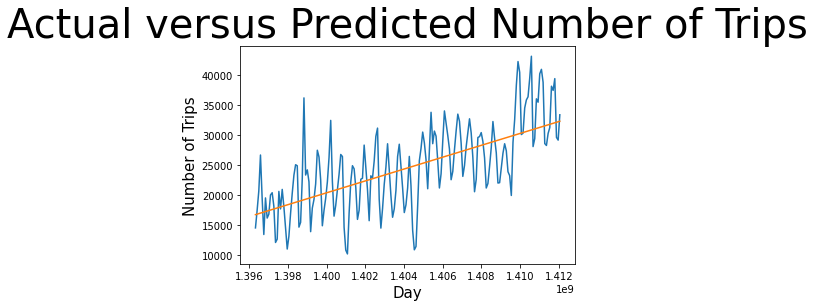

In [64]:
sns.lineplot(data=predictions_df, x="unix_timestamp", y = "Number of Trips")
sns.lineplot(data=predictions_df, x="unix_timestamp", y = "newPrediction")
plt.xlabel("Day")
plt.ylabel("Number of Trips")
plt.title("Actual versus Predicted Number of Trips")

In [60]:
daily_df["Day"]

0     2014-07-30
1     2014-08-11
2     2014-07-16
3     2014-09-10
4     2014-08-12
         ...    
178   2014-06-20
179   2014-05-09
180   2014-05-07
181   2014-05-02
182   2014-04-03
Name: Day, Length: 183, dtype: datetime64[ns]

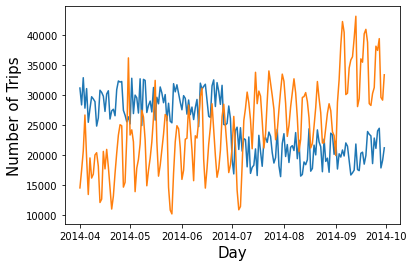

In [61]:
sns.lineplot(x=daily.toPandas()["Day"], y=yf, palette="viridian")
sns.lineplot(x=daily.toPandas()["Day"], y=daily.toPandas()["Number of Trips"])
plt.show()

The expected prediction is the blue line. It appears that from the graph, the blue line captures the overall trend well, but there is a lot of noise and many outliers, so the predictions may not be accurate.
My next step will be to average the days by every 4 days in order to get a better estimate of the overall trend and reduce noise.

In [36]:
import statsmodels.tsa.stattools as tsa
result = tsa.adfuller(daily.toPandas()["Number of Trips"], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   

ADF Statistic: -1.2749083309371672
n_lags: 0.6405721891464482
p-value: 0.6405721891464482
Critial Values:
   1%, -3.4698858990744115
Critial Values:
   5%, -2.8789026251889647
Critial Values:
   10%, -2.5760266680839004


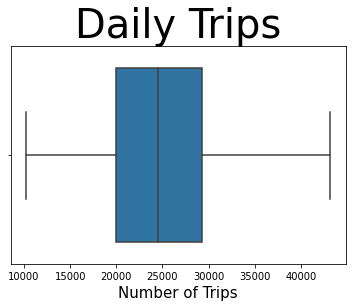

In [37]:
sns.boxplot(data = daily.toPandas(), x = "Number of Trips")
plt.title("Daily Trips")
plt.show()

The distribution of daily trips appears to be roughly normally distributed. This is consistent with the pattern of outliers on the graph.

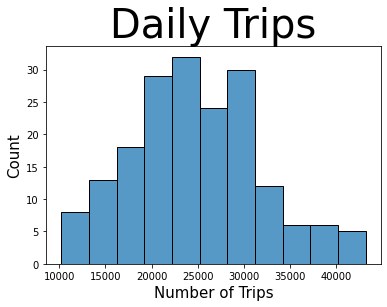

In [38]:
sns.histplot(data = daily.toPandas(), x = "Number of Trips")
plt.title("Daily Trips")
plt.show()

In [39]:
daily.sort(F.col("Number of Trips").desc()).show()

+-------------------+---------------+--------------+
|                Day|Number of Trips|unix_timestamp|
+-------------------+---------------+--------------+
|2014-09-13 00:00:00|          43205|    1410580800|
|2014-09-05 00:00:00|          42319|    1409889600|
|2014-09-19 00:00:00|          41017|    1411099200|
|2014-09-06 00:00:00|          40520|    1409976000|
|2014-09-18 00:00:00|          40274|    1411012800|
|2014-09-12 00:00:00|          39540|    1410494400|
|2014-09-27 00:00:00|          39468|    1411790400|
|2014-09-20 00:00:00|          38864|    1411185600|
|2014-09-04 00:00:00|          38360|    1409803200|
|2014-09-25 00:00:00|          38203|    1411617600|
|2014-09-26 00:00:00|          37504|    1411704000|
|2014-09-11 00:00:00|          36439|    1410408000|
|2014-04-30 00:00:00|          36251|    1398830400|
|2014-09-16 00:00:00|          36092|    1410840000|
|2014-09-10 00:00:00|          35910|    1410321600|
|2014-09-17 00:00:00|          35531|    14109

In [40]:
daily.sort(F.col("Number of Trips")).show()

+-------------------+---------------+--------------+
|                Day|Number of Trips|unix_timestamp|
+-------------------+---------------+--------------+
|2014-05-26 00:00:00|          10202|    1401076800|
|2014-05-25 00:00:00|          10841|    1400990400|
|2014-07-05 00:00:00|          10890|    1404532800|
|2014-04-20 00:00:00|          11017|    1397966400|
|2014-07-06 00:00:00|          11443|    1404619200|
|2014-04-13 00:00:00|          12112|    1397361600|
|2014-04-14 00:00:00|          12674|    1397448000|
|2014-04-21 00:00:00|          13162|    1398052800|
|2014-04-06 00:00:00|          13445|    1396756800|
|2014-05-04 00:00:00|          13918|    1399176000|
|2014-07-04 00:00:00|          14148|    1404446400|
|2014-06-15 00:00:00|          14511|    1402804800|
|2014-04-01 00:00:00|          14546|    1396324800|
|2014-04-19 00:00:00|          14602|    1397880000|
|2014-05-24 00:00:00|          14651|    1400904000|
|2014-04-27 00:00:00|          14677|    13985

# Averaging Every 4 Days
In order to reduce noise, I'm going to run a new model by averaging every few days and seeing how my results change.

In [41]:
from pyspark.sql.window import Window
df_4days = daily.withColumn('unix_time', F.unix_timestamp('Day', 'yyyy-MM-dd'))

winSpec = Window.orderBy('unix_time').rangeBetween(-2*86400, 0)
df_4days = df_4days.withColumn('rolling_avg', F.avg('Number of Trips').over(winSpec))
df_4days = df_4days.withColumn('rolling_sum', F.sum('Number of Trips').over(winSpec))
df_4days.orderBy('Day').show(20, False)


22/05/09 18:29:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/09 18:29:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/09 18:29:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/09 18:29:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+---------------+--------------+----------+------------------+-----------+
|Day                |Number of Trips|unix_timestamp|unix_time |rolling_avg       |rolling_sum|
+-------------------+---------------+--------------+----------+------------------+-----------+
|2014-04-01 00:00:00|14546          |1396324800    |1396324800|14546.0           |14546      |
|2014-04-02 00:00:00|17474          |1396411200    |1396411200|16010.0           |32020      |
|2014-04-03 00:00:00|20701          |1396497600    |1396497600|17573.666666666668|52721      |
|2014-04-04 00:00:00|26714          |1396584000    |1396584000|21629.666666666668|64889      |
|2014-04-05 00:00:00|19521          |1396670400    |1396670400|22312.0           |66936      |
|2014-04-06 00:00:00|13445          |1396756800    |1396756800|19893.333333333332|59680      |
|2014-04-07 00:00:00|19550          |1396843200    |1396843200|17505.333333333332|52516      |
|2014-04-08 00:00:00|16188          |1396929600   

In [42]:
X = df_4days.toPandas()
list(X)

22/05/09 18:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/09 18:29:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/09 18:30:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/05/09 18:30:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


['Day',
 'Number of Trips',
 'unix_timestamp',
 'unix_time',
 'rolling_avg',
 'rolling_sum']

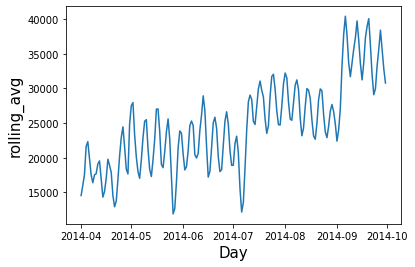

In [43]:
sns.lineplot(x=X["Day"], y=X["rolling_avg"])
plt.show()

For this graph, we see the same general pattern of increasing, but we have fewer sharp peaks and there appears to be less noise. So this is good for a start. For a comparison, I've included the original graph below. The next step will be to fit a linear regression model to rolling_avg to see if there is a difference, and if so, how significant it is.

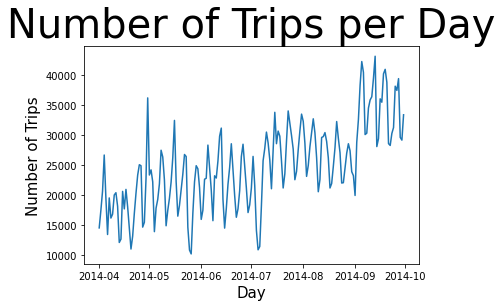

In [44]:
sns.lineplot(data=daily.toPandas(), x="Day", y = "Number of Trips")
plt.title("Number of Trips per Day")
plt.show()

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as sp
y=np.array(X['rolling_avg'].dropna().values, dtype=float)
x=np.array(pd.to_datetime(X['Day'].dropna()).index.values, dtype=float)
slope, intercept, r_value, p_value, std_err =sp.linregress(x,y)
xf = np.linspace(min(x),max(x),len(x))
xf1 = xf.copy()
xf1 = pd.to_datetime(xf1)
yf = (slope*xf)+intercept
print('r = ', r_value, '\n', 'p = ', p_value, '\n', 's = ', std_err)

r =  0.7620880281146266 
 p =  5.247733832340787e-36 
 s =  5.730232304351305


In [46]:
(slope, intercept)

(90.73915001605666, 16427.65538132573)

For every day, we expect the average over 4 days for the number of rides to increase by 90 rides.

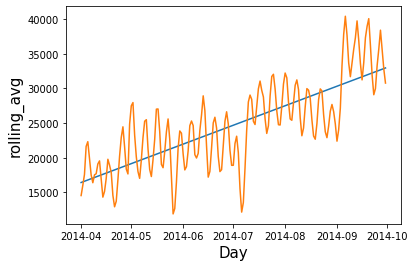

In [47]:
sns.lineplot(x=X["Day"], y=yf, palette="viridian")
sns.lineplot(x=X["Day"], y=X["rolling_avg"])
plt.show()

The line of best fit here looks like a straight line and appears to follow the general pattern better. So overall, the pattern over 4 days is better.

# Conclusions
Overall, from the plots we can see a clear difference between the number of rides by hour and by day.